# **Introdução**

Primeiramente, exportamos os pacotes necessários. 

Foco no pacote LibROSA, que é específico para processamento de sinais de áudio e música em Python.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import librosa

# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

É necessário atualizar o LibROSA para a versão 0.7, pois a versão que vem com o colab é mais antiga. 

In [22]:
!pip install librosa --upgrade

     |████████████████████████████████| 1.6MB 2.7MB/s 
  Created wheel for librosa: filename=librosa-0.7.0-cp36-none-any.whl size=1598345 sha256=8034b9497cb83a0bdeb9a8e04c69852a6fa874dd1616c9cd71d6c7796b69c2c3
  Stored in directory: /root/.cache/pip/wheels/49/1d/38/c8ad12fcad67569d8e730c3275be5e581bd589558484a0f881
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


Após atualizar o pacote LibROSA, clique em "Runtime" e em seguida em "Restart Runtime".

Após isso, rode os blocos de código acima novamente.

Utilizando o Google Colab, é possível definir seu google Drive como diretório. 

In [0]:
# Using google drive as directory

#from google.colab import drive
#drive.mount('/gdrive')

#%cd /gdrive

# **Experimentando com um tom puro**

Nos próximos blocos de código analisaremos um tom puro nos domínios do tempo e da frequência.

Para o domínio do tempo, plotamos a amplitude do sinal no eixo Y e o tempo, em segundos, no eixo X.

Para o domínio da frequência, plotamos a magnitude da Transformada de Fourier (FT) do sinal no eixo Y e a frequência, em Hz, no eixo X. 
Para obtermos a magnitude da Tranformada de Fourier do sinal, utilizamos a função FFT, que é a Tranformada Rápida de Fourier (Fast Fourier Transform).

Após isso, realizaremos a operação da Transformada Inversa de Fourier por meio da função IFFT, a fim de obtermos novamente o sinal no domínio do tempo.

In [2]:
# Experiencing with a pure tone - Time and Frequency domains

sample_rate = 1000
total_sampling_time = 0.5
num_samples = sample_rate * total_sampling_time

t = np.linspace(0, total_sampling_time, num_samples)

frequency_in_hz = 100
wave_amplitude = 5
f = lambda x: wave_amplitude * np.sin(frequency_in_hz * 2*np.pi*x)
    
sampled_f = [f(i) for i in t]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


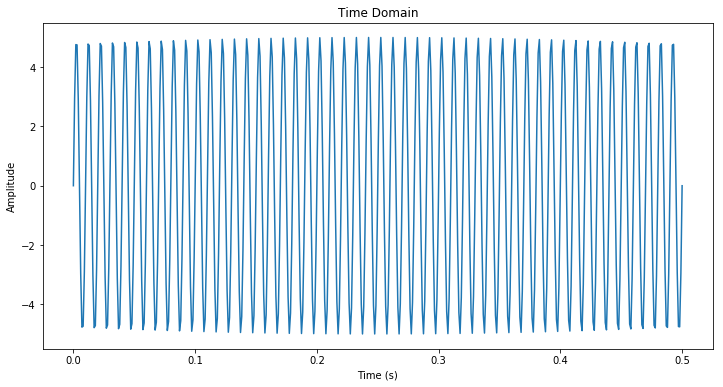

In [3]:
# Graph in time domain of the pure tone

setup_graph(title='Time Domain', x_label='Time (s)', y_label='Amplitude', fig_size=(12,6))
_ = plt.plot(t, sampled_f)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


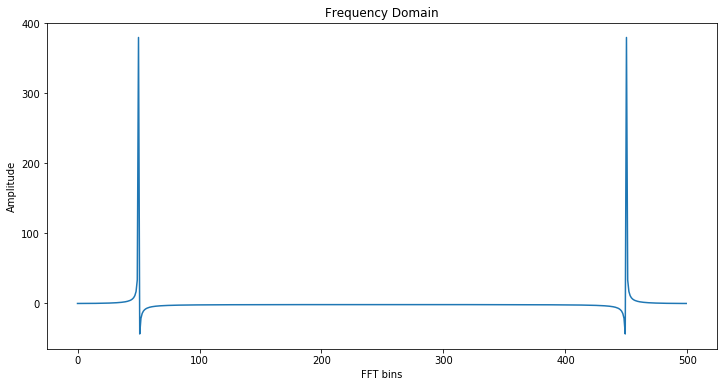

In [4]:
# Taking the FFT and plotting it

fft_output = np.fft.fft(sampled_f)

setup_graph(title='Frequency Domain', x_label='FFT bins', y_label='Amplitude', fig_size=(12,6))
_ = plt.plot(fft_output)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


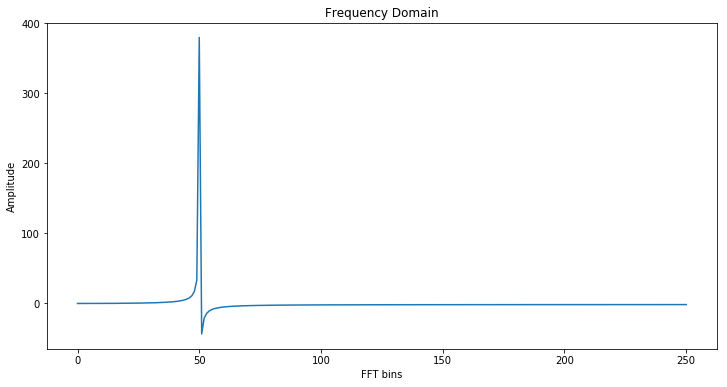

In [5]:
# It is mirrored. Why?
# Because it is a complex-input fourier transform, and for real input, the 2nd half will always be a mirror image.
# For real-valued input, the fft output is always symmetric.
# Let's use the real FFT.

rfft_output = np.fft.rfft(sampled_f)

setup_graph(title='Frequency Domain', x_label='FFT bins', y_label='Amplitude', fig_size=(12,6))
_ = plt.plot(rfft_output)

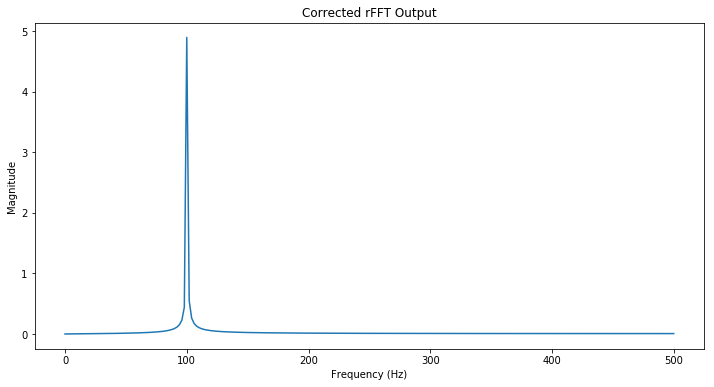

In [6]:
# The axis are incorrect. Let's make this right.

# X-axis should be Frequency and Y-axis should be Amplitude

# X-axis
xaxis_freq = [(i*1.0/num_samples)*sample_rate for i in range(int(num_samples)//2+1)]

# Y-axis
yaxis_magn = [np.sqrt(i.real**2 + i.imag**2)/len(rfft_output) for i in rfft_output]

# Correct plot
setup_graph(title='Corrected rFFT Output', x_label='Frequency (Hz)', y_label='Magnitude', fig_size=(12,6))
_ = plt.plot(xaxis_freq, yaxis_magn)

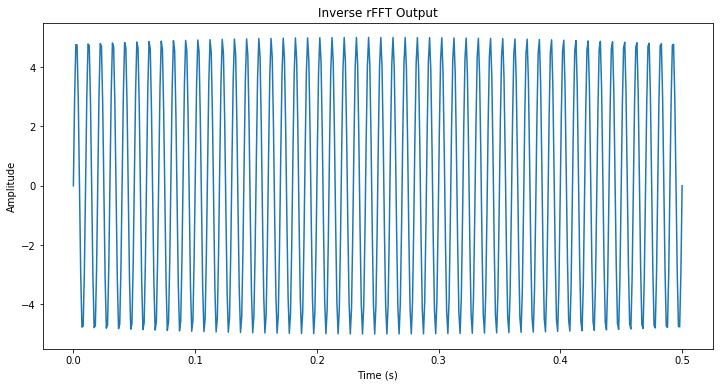

In [7]:
# Re-obtaining the original signal through the Inverse FFT

irfft_output = np.fft.irfft(rfft_output)

setup_graph(title='Inverse rFFT Output', x_label='Time (s)', y_label='Amplitude', fig_size=(12,6))
_ = plt.plot(t, irfft_output)

# **Experimentando com um som mais complexo**

Analisaremos agora uma vogal, que é um som mais complexo do que um tom puro, pois ela é composta por mais de uma frequência.




In [0]:
# Importing the sound of a vowel (ah)

# With Scipy
import scipy.io.wavfile

(sample_rate, input_signal) = scipy.io.wavfile.read("/vowel_ah.wav")

# With LibROSA
x, fs = librosa.load("/vowel_ah.wav")

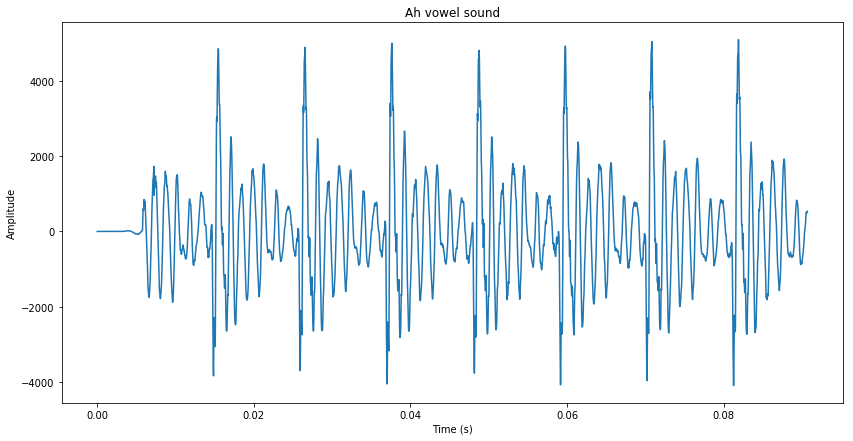

In [3]:
# Plotting the raw sound (without pre-processing)

time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)
setup_graph(title='Ah vowel sound', x_label='Time (s)', y_label='Amplitude', fig_size=(14,7))
_ = plt.plot(time_array[0:4000], input_signal[0:4000])

Pode-se realizar um pré-processamento básico no sinal de modo que ele se torne mais "tratável".

No caso, serão realizadas a pré-ênfase e a normalização.

A pré-ênfase aumenta a magnitude das componentes de alta frequência do sinal (é um filtro passa-altas) de modo que essas componentes fiquem menos susceptíveis a ruído.

A normalização faz com que o valor máximo do sinal se torne 1, evitando amplitude muito altas. 

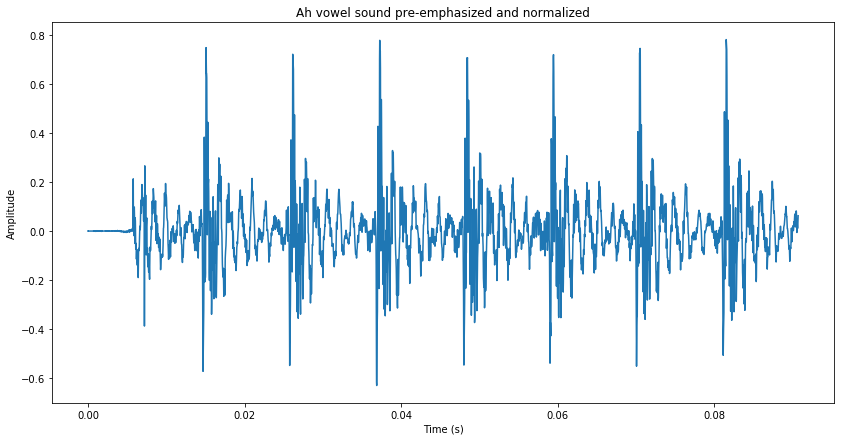

In [4]:
# Basic pre-processing

L = len(input_signal)
# Pre-emphasis
input_signal = input_signal[2:L] - 0.97*input_signal[1:(L-1)]
# Normalization
input_signal = input_signal/max(abs(input_signal))

setup_graph(title='Ah vowel sound pre-emphasized and normalized', x_label='Time (s)', y_label='Amplitude', fig_size=(14,7))
_ = plt.plot(time_array[0:4000], input_signal[0:4000])

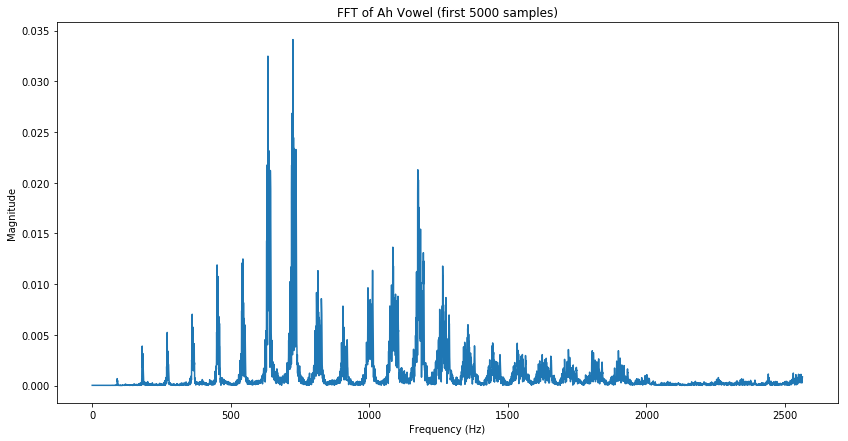

In [5]:
# FFT of the vowel ah

fft_out = np.fft.rfft(input_signal)
yaxis_magn = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
num_samples = len(input_signal)
xaxis_freq = [(i*1.0/num_samples)*sample_rate for i in range(int(num_samples)//2+1)]

setup_graph(title='FFT of Ah Vowel (first 5000 samples)', x_label='Frequency (Hz)', y_label='Magnitude', fig_size=(14,7))
_ = plt.plot(xaxis_freq[0:5000], yaxis_magn[0:5000])

# **Espectrograma**

Pela análise no domínio do tempo acima, perbece-se que a vogal ah é composta por várias frequências.

Um outro modo de visualização do sinal no domínio da frequência é o espectrograma, que privilegia a variação do espectro ao longo do tempo (FFT ao longo do tempo).

O tamanho da janela do espectrograma (tamanho da FFT utilizada) influencia nos resultados. Abaixo temos espectrogramas do mesmo sinal, mas com FFTs de tamanho 128, 256, 512 e 1024.

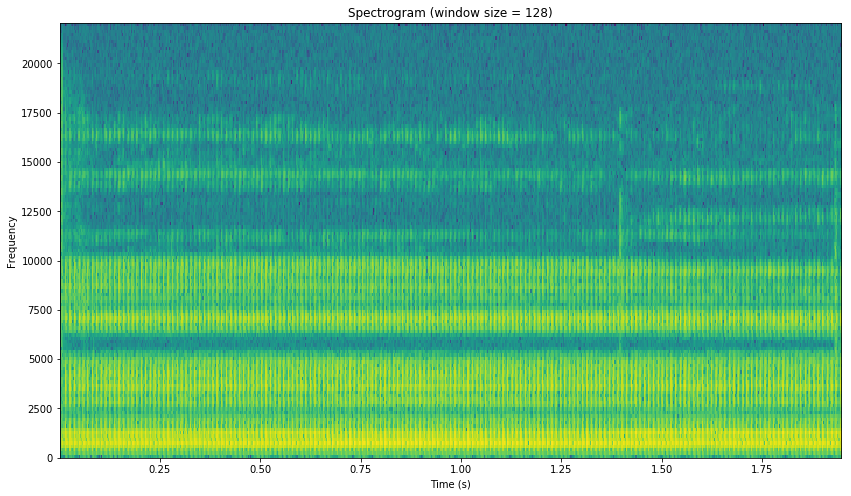

In [12]:
# Spectrogram (FFT over time)

setup_graph(title='Spectrogram (window size = 128)', x_label='Time (s)', y_label='Frequency', fig_size=(14,8))
_ = plt.specgram(input_signal, Fs=sample_rate)

Vamos experimentar com o espectrograma de um som ainda mais complexo.

Que tal uma série de vogais? 
"Ó o auê aí, ó."

In [0]:
# Importing the complex sound (do-re-mi)

(fs, doremi) = scipy.io.wavfile.read("/do-re-mi.wav")

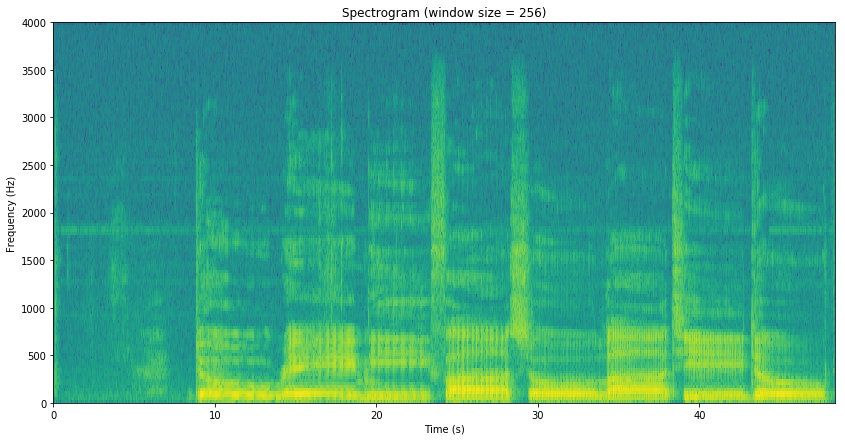

In [16]:
# The length of the window has an effect on the spectrogram

setup_graph(title='Spectrogram (window size = 256)', x_label='Time (s)', y_label='Frequency (Hz)', fig_size=(14,7))
_ = plt.specgram(doremi, Fs=8000, NFFT=256)

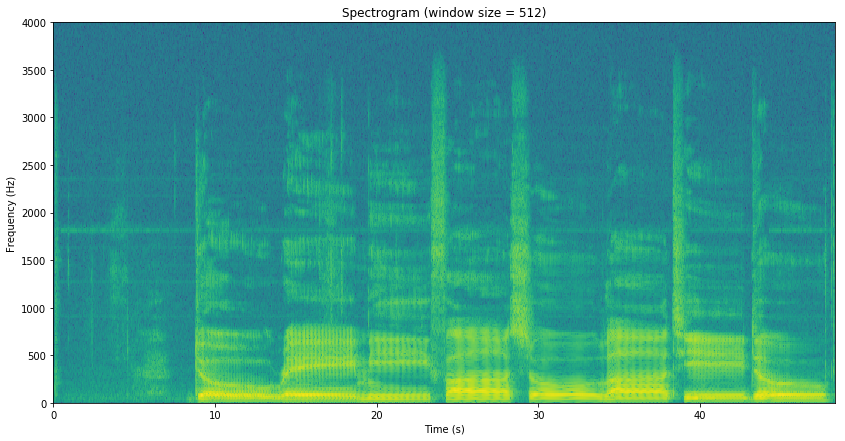

In [17]:
setup_graph(title='Spectrogram (window size = 512)', x_label='Time (s)', y_label='Frequency (Hz)', fig_size=(14,7))
_ = plt.specgram(doremi, Fs=8000, NFFT=512)

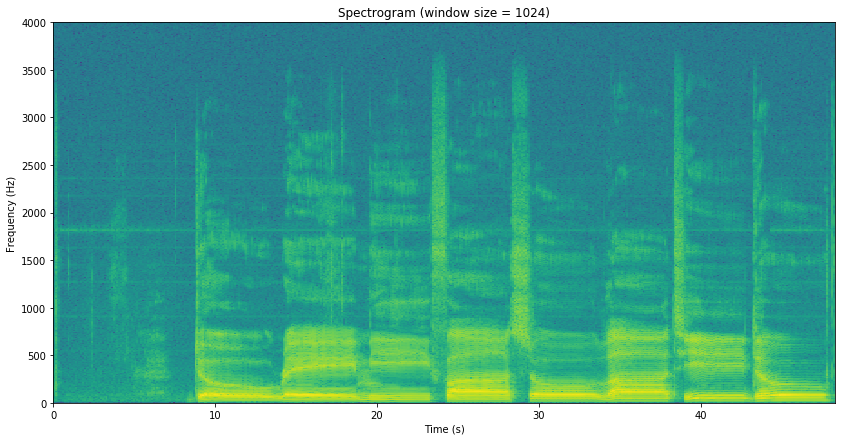

In [18]:
setup_graph(title='Spectrogram (window size = 1024)', x_label='Time (s)', y_label='Frequency (Hz)', fig_size=(14,7))
_ = plt.specgram(doremi, Fs=8000, NFFT=1024)

Com uma FFT maior (mais amostras em cada análise), há mais informações sobre quais frequências estão contidas em cada FFT (resolução de frequência). Por outro lado, tem-se menos janelas e a resoluçao temporal é pior.

Com uma FFT menor (menos amostras em cada análise), há menor resolução de frequência, mas maior resolução temporal.

Uma alta resolução temporal é obtida por meio de FFTs pequenas.

Um alta resolução de frequência é obtida por meio de FFTs grandes.

Isso represente a dualidade entre tempo e frequência (o princío da incerteza tempo/frequência).

# **Extração de Características**

Pode-se representar digitalmente sinais de áudio e fala por meio de parâmetros diferentes da amplitude do sinal em cada amostra. Dois exemplos são os Coeficientes de Codificação Preditiva Linear (LPC) e o Coeficientes Mel-Ceptrais (MFCC).

Deste modo, os sinais são representados de forma mais compacta, facilitando seu processamento.

Um primeiro passo desejável é dividir o sinal em quadros, de modo que cada quadro seja processado independentemente.

Para resultados melhores, os quadros devem se sobrepor. Além disso, um janela (usualmente de Hamming) pode ser aplicada em cada quadro de modo a melhorar a continuidade entre eles.

O tamanho de cada quadro é geralmente entre 20ms e 40ms. O número de amostras de cada quadro depende da frequência de amostragem do sinal e o do tamanho do quadro desejado.

In [0]:
# A common technique used in audio processing is dividing the signal in frames. 
# We divide the signal in small frames (around 40ms) and process each one separately.
# The frames should superpose for better results.
# We apply a window in each of the frames to improve continuity between them.

# First, let's downsample the signal to 10kHz. It is more than sufficient for speech.
new_sample_rate = 10000
new_input_signal = [input_signal[i] for i in range(0, len(input_signal), sample_rate//new_sample_rate)]

window_duration = 0.04
window_size = window_duration * new_sample_rate
hop_size = window_size // 2

# We utilize a Hamming window, but other windows may be used.
window = scipy.hamming(window_size)

In [0]:
# Applying the window to each frame

# But for that we must first adjust the length of the signal, because the number of frames must be an integer.
L = len(new_input_signal)
rest = L % window_size
new_input_signal = new_input_signal[1:int(L - rest)]

# Applying the window
windowed = [window * new_input_signal[i:int(i+window_size)] for i in range(0, int(len(new_input_signal)-window_size), int(hop_size))]

# Windowed is now an array with dimension 102x400: 102 frames with 400 samples each.

**LPC (Linear Predictive Coding)**

A técnica de LPC consiste na predicão de cada amostra por meio das amostras anteriores.
Os coeficientes LPC são os pesos de cada amostra anterior na composição da amostra atual.

Geralmente são utilizados de 8 a 16 coeficientes LPC para aplicações de fala.

Cada janela do sinal pode ser, portanto, representada por 8 a 16 coeficientes.

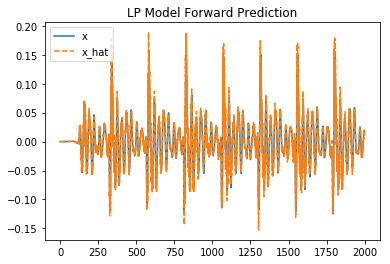

In [8]:
# LPC Example

a = librosa.lpc(input_signal, 10)

x_hat = scipy.signal.lfilter([0] + -1*a[1:], [1], x)
plt.figure()
plt.plot(x[1:2000])
plt.plot(x_hat[1:2000], linestyle='--')
plt.legend(['x', 'x_hat'])
plt.title('LP Model Forward Prediction')
plt.show()

**MFCC (Mel-frequency cepstral coefficients)**

A explicação teórica da extração dos MFCCs é mais complexa que a da LPC. A ideia, contudo, é uma representação espectral que indica a magnitude do espectro do sinal em determinadas faixas de frequência.

Essas faixas de frequência são determinadas por um banco de filtros na escala de frequência Mel, que foi desenvolvida para ser mais fiel à percepção auditiva humana.

Há implementações prontas de MFCC, assim como há para LPC. O pacote LibROSA providencia uma delas. 

O site Practical Cryptography traz detalhes da teoria por trás da extração dos MFCCs.

In [0]:
# MFCC example

mfccs = librosa.feature.mfcc(y=input_signal, sr=8000, n_mfcc=40)

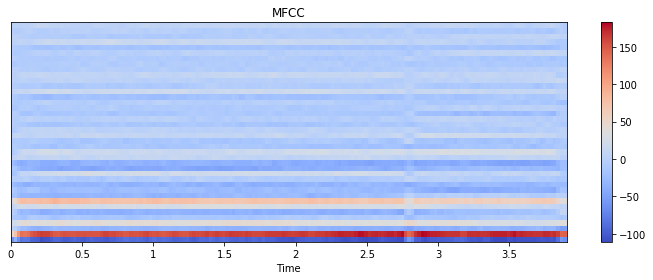

In [11]:
import librosa.display

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# Referências

- Sound Analysis with the Fourier Transform and Python - OSCON 2013 Talk by Caleb Madrigal
https://github.com/calebmadrigal/FourierTalkOSCON

- Learn how to Build your own Speech-to-Text Model (using Python) by Aravind Pai
https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/

- Getting Started with Audio Data Analysis using Deep Learning (with case study) by Faizan Shaikh
https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/

- Basic Sound Processing in Python by Allen B. Downey www.tinyurl.com/scipy15downey

- Ciência e Tecnologia da Fala EEE940 - PPGEE UFMG by Hani Camille Yehia, 2019

- MFCC tutorial by Practical Cryptography http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

- LibROSA LIbrary
https://librosa.github.io/librosa/0.7.0/index.html
